### 2 mininets with 1 layers joined on axis 1 to and go through 2 layers, 3*preamble_length node layers - connection layer had 2*3*preamble length, nn.sigmoid - output layer identity, preamble_length = 100, channel size = 2, learning rate = 0.0001, decay = 1-10^-10

In [23]:
import numpy as np
import scipy.signal as sig
from numpy import linalg as LA
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

# Create training and test data for the NN

# number of random channels that will be trained and tested on
num_train=500000# 1000000
num_test=10000
SNR = 10

# assume we know the channel_length
channel_length = 2
num_preambles = 1
preamble_length = 100
recieved_length = preamble_length + channel_length - 1

preambles = np.random.randint(0,2,(num_preambles,preamble_length)) 

def add_awgn_noise(signal,SNR_dB):
    """  Adds AWGN noise vector to signal 
         to generate a resulting signal vector y of specified SNR in dB
    """
    L=len(signal)
    SNR = 10**(SNR_dB/10.0) #SNR to linear scale
    Esym=np.sum(np.square(np.abs(signal)))/L #Calculate actual symbol energy
    N0=Esym/SNR; #Find the noise spectral density
    if(isinstance(signal[0], complex)):
        noiseSigma=np.sqrt(N0/2.0)#Standard deviation for AWGN Noise when x is complex
        n = noiseSigma*(np.random.randn(1,L)+1j*np.random.randn(1,L))#computed noise 
    else:
        noiseSigma = np.sqrt(N0);#Standard deviation for AWGN Noise when x is real
        n = noiseSigma*np.random.randn(1,L)#computed noise
    y = signal + n #received signal
    return signal

# channel_train: assume we are working with just real parts, list of all used channels
# preamble_train: use same channel on num_preambles different preambles and store them to train with
# true_preambles: the same true preamble over and over again to use as an input with the convolved preamble
channel_train = np.zeros((num_train,channel_length))
preamble_train = np.zeros((num_train*num_preambles, preamble_length))
true_preambles = np.zeros((num_train*num_preambles, preamble_length))

channel_test = np.zeros((num_test,channel_length))
preamble_test = np.zeros((num_test*num_preambles, preamble_length))
#true_preambles_test = np.zeros((num_test*num_preambles, preamble_length))

In [32]:
for i in range(num_train*num_preambles):
    true_preambles[i] = preambles[0]
    

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]


In [34]:
for i in range(0, num_train):
    if i%50000 == 0:
        print(i)
    channel_train[i,:]=np.random.uniform(0.2,1,channel_length)
    # if the total power is greater than 1, then normalize
    if sum(channel_train[i])>=1:
        channel_train[i] = channel_train[i]/(sum(channel_train[i]))
        
    for k in range(num_preambles):
        preamble_train[i+k,:] = add_awgn_noise(sig.convolve(preambles[k], channel_train[i], mode='same'), SNR)

print("Made Train Data")
        
for i in range(0, num_test):
    if i%1000 == 0:
        print(i)
    channel_test[i,:]=np.random.uniform(0.2,1,channel_length)
    # if the total power is greater than 1, then normalize
    if sum(channel_test[i])>=1:
        channel_test[i] = channel_test[i]/(sum(channel_test[i]))
        
    for k in range(num_preambles):
        preamble_test[i+k,:] = add_awgn_noise(sig.convolve(preambles[k], channel_test[i], mode='same'), SNR)
        #true_preambles_test[i+k:] = preambles[0]
        
print("Made Test Data")

0
50000
100000
150000
200000
250000
300000
350000
400000
450000
Made Train Data
0
Made Test Data


In [35]:
print(len(preamble_test[0]))

100


Epoch 0, Cost 1.0170563459396362, Test Cost: 0.6949848532676697
Epoch 100, Cost 0.017994221299886703, Test Cost: 0.017619509249925613
Epoch 200, Cost 0.010345968417823315, Test Cost: 0.011093485169112682
Epoch 300, Cost 0.005711496341973543, Test Cost: 0.0056357732973992825
Epoch 400, Cost 0.0033075809478759766, Test Cost: 0.0032616714015603065
Epoch 500, Cost 0.002519149798899889, Test Cost: 0.00235192384570837
Epoch 600, Cost 0.0019552966114133596, Test Cost: 0.001766251982189715
Epoch 700, Cost 0.0013942564837634563, Test Cost: 0.0013184983981773257
Epoch 800, Cost 0.0008714309660717845, Test Cost: 0.0009626600076444447
Epoch 900, Cost 0.0005973895895294845, Test Cost: 0.0006711747846566141
Epoch 1000, Cost 0.00046997424215078354, Test Cost: 0.0004433997964952141
Epoch 1100, Cost 0.00026666707708500326, Test Cost: 0.0002769383427221328
Epoch 1200, Cost 0.00017275959544349462, Test Cost: 0.00016220202087424695
Epoch 1300, Cost 8.987929322756827e-05, Test Cost: 9.060992306331173e-05
E

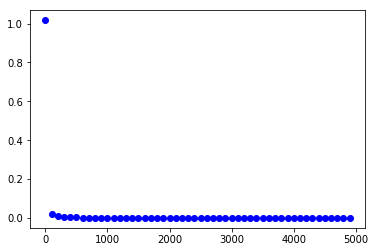

In [80]:
# fix a random seed to have the same results
np.random.seed()

learning_rate = 0.0001#0.001
epochs = 5000#10000
batch_size = 1000
test_averaging=100
decay = 1 - 10*1e-10#1 - 10*1e-10

# placeholders for input and output
adaptive_learning_rate = tf.placeholder_with_default(learning_rate, [], name="adaptive_learning_rate")
recieved_preamble = tf.placeholder(tf.float32, [None, preamble_length], name="recieved_preamble")
actual_preamble = tf.placeholder(tf.float32, [None, preamble_length], name="actual_preamble")
real_channel = tf.placeholder(tf.float32, [None, channel_length], name="real_channel")

layer1_1 = tf.contrib.layers.fully_connected(actual_preamble, num_outputs=3*preamble_length, activation_fn=tf.nn.sigmoid)
#layer1_2 = tf.contrib.layers.fully_connected(layer1_1, num_outputs=3*preamble_length, activation_fn=tf.nn.sigmoid)

layer2_1 = tf.contrib.layers.fully_connected(recieved_preamble, num_outputs=3*preamble_length, activation_fn=tf.nn.sigmoid)
#layer2_2 = tf.contrib.layers.fully_connected(layer2_1, num_outputs=3*preamble_length, activation_fn=tf.nn.sigmoid)

#combined_12 = tf.concat([layer1_2, layer2_2], axis=1)
combined_12 = tf.concat([layer1_1, layer2_1], axis=1)

layer3 = tf.contrib.layers.fully_connected(combined_12, num_outputs=2*3*preamble_length, activation_fn=tf.nn.sigmoid)
layer4 = tf.contrib.layers.fully_connected(layer3, num_outputs=channel_length, activation_fn=tf.identity)

channel_estimate = layer4

cost_fn = tf.reduce_mean(tf.reduce_mean((real_channel-channel_estimate)**2, axis=1))
optimizer = tf.train.AdamOptimizer(learning_rate=adaptive_learning_rate).minimize(cost_fn)

init = tf.global_variables_initializer()
saver = tf.train.Saver()
plt.figure()

train_costs = []
train_channels = []
test_costs = []
test_channels = []

with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(epochs):
        
        # for each batch start the batch with passing the first preamble through the identity channel
        identity_channel = np.zeros(channel_length)
        identity_channel[0] = 1
        preamble_batch = sig.convolve(preambles[0], identity_channel, mode='same')
        real_channel_batch = identity_channel
        
        for rand in range(0,batch_size-1):
            rand_int = np.random.randint(0,num_train*num_preambles)
            preamble_batch = np.vstack((preamble_batch, preamble_train[rand_int]))
            real_channel_batch = np.vstack((real_channel_batch, channel_train[rand_int]))
            
        preamble_batch.reshape((batch_size, preamble_length))
        real_channel_batch.reshape((batch_size, channel_length))
        
        _,cost,channel_est = sess.run(
            [optimizer, cost_fn, channel_estimate], 
            feed_dict={actual_preamble: true_preambles[:batch_size],recieved_preamble: preamble_batch, 
                       real_channel: real_channel_batch ,adaptive_learning_rate: learning_rate * (decay**epoch)})
        
        train_costs.append(cost)
        train_channels.append(channel_est)
        
        if epoch % 100 == 0: 
            plt.plot(epoch, cost, 'bo')
            test_cost, test_channel = sess.run(
                [cost_fn, channel_estimate], feed_dict={actual_preamble: true_preambles[:num_test],recieved_preamble: preamble_test, real_channel: channel_test})
            print('Epoch {}, Cost {}, Test Cost: {}'.format(epoch, cost, test_cost))
            
            test_costs.append(test_cost)
            test_channels.append(test_channel)

    saved_model = saver.save(sess, 'my-test-model')

Text(0,0.5,'Log Cost on Training set')

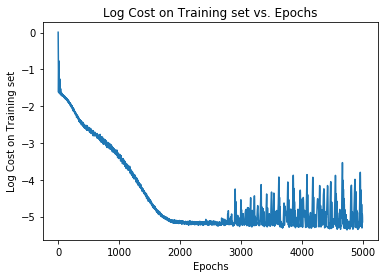

In [81]:
plt.plot(np.log10(train_costs))
plt.title("Log Cost on Training set vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Log Cost on Training set")

Text(0,0.5,'Log Cost on Test set')

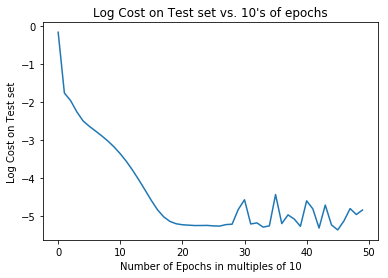

In [82]:
plt.plot(np.log10(test_costs))
plt.title("Log Cost on Test set vs. 10's of epochs")
plt.xlabel("Number of Epochs in multiples of 10")
plt.ylabel("Log Cost on Test set")

In [83]:
print(test_costs)

[0.69498485, 0.017619509, 0.011093485, 0.0056357733, 0.0032616714, 0.0023519238, 0.001766252, 0.0013184984, 0.00096266001, 0.00067117478, 0.0004433998, 0.00027693834, 0.00016220202, 9.0609923e-05, 4.9088099e-05, 2.6332653e-05, 1.4895567e-05, 9.7313059e-06, 7.3853657e-06, 6.4143583e-06, 6.0457774e-06, 5.8915516e-06, 5.7685738e-06, 5.7738289e-06, 5.8105393e-06, 5.6321655e-06, 5.5765772e-06, 6.0945267e-06, 6.2534718e-06, 1.5329459e-05, 2.7451231e-05, 6.3377433e-06, 6.7668052e-06, 5.2410642e-06, 5.640687e-06, 3.7558832e-05, 6.4891724e-06, 1.0977328e-05, 8.5620131e-06, 5.4972638e-06, 2.5668573e-05, 1.5805588e-05, 4.9589371e-06, 1.9897994e-05, 5.9956878e-06, 4.4223179e-06, 7.5812468e-06, 1.6087341e-05, 1.1245916e-05, 1.4753686e-05]


In [84]:
print(channel_test[90:100])

[[ 0.410446    0.45406902]
 [ 0.36399433  0.22458202]
 [ 0.37392983  0.62607017]
 [ 0.42199069  0.57800931]
 [ 0.6017185   0.3982815 ]
 [ 0.25283066  0.65221732]
 [ 0.45035209  0.54964791]
 [ 0.51680878  0.45090477]
 [ 0.28705173  0.71294827]
 [ 0.60943124  0.39056876]]


In [85]:
print(test_channels[2][90:100])

[[ 0.46417308  0.48768815]
 [ 0.48691222  0.42620715]
 [ 0.43849933  0.54503381]
 [ 0.45039913  0.52251977]
 [ 0.49492833  0.43810034]
 [ 0.41995215  0.57398164]
 [ 0.45742854  0.50921166]
 [ 0.47790062  0.46834785]
 [ 0.41706106  0.58555186]
 [ 0.49683419  0.43448025]]
